In [65]:
import csv
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pandas as pd

df = pd.read_csv('labels.csv')
df = df.query('photo_quality == 1')

df_train = df.loc[(df.is_validation == 0) & (df.is_final_validation == 0)]
df_valid = df.loc[(df.is_validation == 1)]
df_test = df.loc[(df.is_final_validation == 1)]

print(df_train.shape)
print(type(df_train))
array = df_train.to_numpy()
print(array.shape)
print(type(array))

print('oh no')


#img = mpimg.imread(array[0])


            

(4908, 10)
<class 'pandas.core.frame.DataFrame'>
(4908, 10)
<class 'numpy.ndarray'>
oh no


In [66]:
labels_cols = ['is_bee', 'is_wasp', 'is_otherinsect']

y_train = df_train.loc[:,['id']+labels_cols]
y_train.set_index('id', inplace = True)
y_valid = df_valid.loc[:,['id']+labels_cols]
y_valid.set_index('id', inplace = True)
y_test = df_test.loc[:,['id']+labels_cols]
y_test.set_index('id', inplace = True)

print(y_train)

       is_bee  is_wasp  is_otherinsect
id                                    
1           1        0               0
5           1        0               0
6           1        0               0
7           1        0               0
8           1        0               0
...       ...      ...             ...
10558       0        0               1
10560       0        0               1
10562       0        0               1
10564       0        0               1
10565       0        0               1

[4908 rows x 3 columns]


In [67]:
import tensorflow as tf
import numpy as np

IMG_Size = 32
BS = 5000

valid_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        horizontal_flip=True,
        vertical_flip = True,
        width_shift_range=0.2, height_shift_range=0.2,
        shear_range=0.2, zoom_range=0.2)


train_generator = train_gen.flow_from_dataframe(dataframe=df_train, 
                                                  x_col="path", y_col=labels_cols, 
                                                  class_mode="raw", 
                                                  target_size=(IMG_Size,IMG_Size), batch_size = BS)
ti, tl = train_generator.next()

valid_generator = valid_gen.flow_from_dataframe(dataframe=df_valid,
                                                  x_col="path", y_col=labels_cols, 
                                                  class_mode="raw", 
                                                  # class_mode="categorical", 
                                                  target_size=(IMG_Size,IMG_Size), batch_size = BS)

#Data til test skal heller ikke normaliseres, men vi skalerer det ligeledes  
test_generator = valid_gen.flow_from_dataframe(dataframe=df_test,
                                                  x_col="path", y_col=labels_cols, 
                                                  class_mode="raw", 
                                                  shuffle = False,
                                                  target_size=(IMG_Size,IMG_Size), batch_size = BS)

Found 4908 validated image filenames.
Found 1043 validated image filenames.
Found 1084 validated image filenames.


In [68]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import pandas as pd

traini, trainl = train_generator.next()
validi, validl = valid_generator.next()
testi, testl = test_generator.next()

print("Shape of x_train pre-processing: ", traini.shape)
print("Shape of y_train pre-processing: ", trainl.shape)

print("Shape of x_val pre-processing: ", validi.shape)
print("Shape of y_val pre-processing: ", validl.shape)

print("Shape of x_test pre-processing: ", testi.shape)
print("Shape of y_test pre-processing: ", testl.shape)

Shape of x_train pre-processing:  (4908, 32, 32, 3)
Shape of y_train pre-processing:  (4908, 3)
Shape of x_val pre-processing:  (1043, 32, 32, 3)
Shape of y_val pre-processing:  (1043, 3)
Shape of x_test pre-processing:  (1084, 32, 32, 3)
Shape of y_test pre-processing:  (1084, 3)


In [69]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout

# Create model architecture
categories = len(labels_cols)


model = Sequential()
model.add(Flatten(input_shape=traini.shape[1:]))
model.add(Dense(1000, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(categories, activation="softmax"))

# Compile the model
model.compile(loss="categorical_crossentropy", optimizer="rmsprop", 
                metrics=["accuracy"])

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_12 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_39 (Dense)             (None, 1000)              3073000   
_________________________________________________________________
dropout_27 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_40 (Dense)             (None, 512)               512512    
_________________________________________________________________
dropout_28 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 3)                 1539      
Total params: 3,587,051
Trainable params: 3,587,051
Non-trainable params: 0
___________________________________________

In [71]:
from keras.callbacks import ModelCheckpoint

mlp_weights_path = "saved_weights/beeswasps_mlp_best.hdf5"

checkpointer_mlp = ModelCheckpoint(filepath=mlp_weights_path, verbose=1, save_best_only=True)
hist_mlp = model.fit(traini, trainl, batch_size=32, 
                   epochs=100, validation_data=(validi, validl),
                   callbacks=[checkpointer_mlp], shuffle=True)

4/154 [==============================] - ETA: 0s - loss: 0.8487 - accuracy: 0.6070
Epoch 00030: val_loss did not improve from 0.91617
154/154 [==============================] - 10s 62ms/step - loss: 0.8487 - accuracy: 0.6070 - val_loss: 0.9381 - val_accuracy: 0.5599
Epoch 31/100
154/154 [==============================] - ETA: 0s - loss: 0.8496 - accuracy: 0.6086
Epoch 00031: val_loss did not improve from 0.91617
154/154 [==============================] - 10s 64ms/step - loss: 0.8496 - accuracy: 0.6086 - val_loss: 0.9536 - val_accuracy: 0.5657
Epoch 32/100
154/154 [==============================] - ETA: 0s - loss: 0.8392 - accuracy: 0.6070
Epoch 00032: val_loss did not improve from 0.91617
154/154 [==============================] - 10s 62ms/step - loss: 0.8392 - accuracy: 0.6070 - val_loss: 0.9805 - val_accuracy: 0.5523
Epoch 33/100
154/154 [==============================] - ETA: 0s - loss: 0.8430 - accuracy: 0.6123
Epoch 00033: val_loss did not improve from 0.91617
154/154 [===========

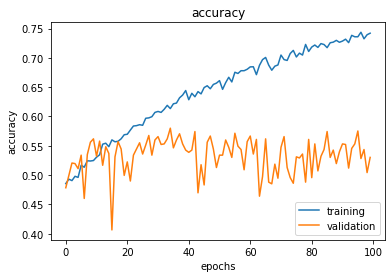

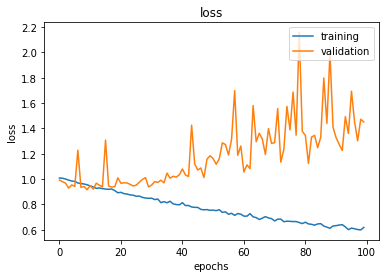

In [72]:
# A chart showing how the accuracy for the training and tests sets evolved
def visualize_training(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.legend(['training', 'validation'], loc='lower right')
    plt.show()
    
    # A chart showing our training vs validation loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['training', 'validation'], loc='upper right')
    plt.show()


#print(hist_mlp.history)
visualize_training(hist_mlp)